This notebook is about visualizing the ripple modulation in the ABI Visual Behaviour Neuropixels dataset on neurons within the hippocampus as well as 

In [3]:
# libraries
import os
import re
import subprocess 
import numpy as np
import pandas as pd
from scipy import io, signal
#from fitter import Fitter, get_common_distributions, get_distributions
import scipy.ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
# for ripple detection
import ripple_detection
from ripple_detection.core import filter_ripple_band
from ripple_detection.simulate import simulate_time
from scipy import signal
import seaborn as sns
#import KernelRegDraft as kreg # custom module, not needed
#import 'Stienmetz2019Reanalyzed/KernelRegDraft.py' as kreg

from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from tqdm import tqdm

from ripple_detection.simulate import simulate_time
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
import xarray as xr
from scipy import interpolate
from scipy.signal import firwin, lfilter


/home/acampbell/miniconda3/envs/allensdk/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# setting paths
# change this as needed:
sdk_cache_dir='/space/scratch/allen_visbehave_data'# path to where the cache for the allensdk is (wehre the lfp is going)
manifest_path = os.path.join(sdk_cache_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
input_dir = '/space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_2sd_envelope'
output_dir = os.path.curdir
global_rip_label = 'no_movement_no_gamma'


In [5]:
def unit_spike_times_alyx_format(session_obj, unit_ids, start_time=0, stop_time=np.inf, as_array=False):
    """
    Returns a DataFrame of spike times for multiple units in a session in the format
    according to the Alyx format
    
    Parameters
    ----------
    session : allensdk session object
    unit_ids : list of unit ids (obtained by session.units.index)
    start_time : float, optional, start time of spike times
    stop_time : float, optional, stop time of spike times
    as_array : bool, optional, if True returns a numpy array instead of a DataFrame
    
    Returns
    -------
    DataFrame or numpy array of spike times
    """
    df = pd.DataFrame(columns=['units', 'times'])

    for unit_id in unit_ids:
        ca1_unit_time = np.array(session_obj.spike_times[unit_id])
        filtered_time = ca1_unit_time[(ca1_unit_time > start_time) & (ca1_unit_time < stop_time)]
        unit_ids_array = np.full(filtered_time.shape, unit_id)
        
        df_temp = pd.DataFrame({
            'units': unit_ids_array,
            'times': filtered_time
        })
        
        df = df = pd.concat([df, df_temp], ignore_index=True)

    df = df.sort_values(by='times')

    if as_array:
        return df.values
    else:
        return df
    
#For smoothing we make halfguassian_kernel1d and halfgaussian_filter1d
def halfgaussian_kernel1d(sigma, radius):
    """
    Computes a 1-D Half-Gaussian convolution kernel.
    """
    sigma2 = sigma * sigma
    x = np.arange(0, radius+1)
    phi_x = np.exp(-0.5 / sigma2 * x ** 2)
    phi_x = phi_x / phi_x.sum()

    return phi_x

def halfgaussian_filter1d(input, sigma, axis=-1, output=None,
                      mode="constant", cval=0.0, truncate=4.0):
    """
    Convolves a 1-D Half-Gaussian convolution kernel.
    """
    sd = float(sigma)
    # make the radius of the filter equal to truncate standard deviations
    lw = int(truncate * sd + 0.5)
    weights = halfgaussian_kernel1d(sigma, lw)
    origin = -lw // 2
    return scipy.ndimage.convolve1d(input, weights, axis, output, mode, cval, origin)

# Assuming you have your signal_array, b, and a defined as before
def finitimpresp_filter_for_LFP(LFP_array, samplingfreq, lowcut = 1, highcut = 250,
                    filter_order = 101):
    
    nyquist = 0.5 * samplingfreq

    # Design the FIR bandpass filter using scipy.signal.firwin
    fir_coeff = signal.firwin(filter_order, [lowcut / nyquist, highcut / nyquist],
                              pass_zero=False, fs=samplingfreq)

    # Apply the FIR filter to your signal_array
    #filtered_signal = signal.convolve(LFP_array, fir_coeff, mode='same', method='auto')
    filtered_signal = signal.lfilter(fir_coeff, 1.0, LFP_array, axis=0)
    return(filtered_signal)

def find_channel_num_in_filename(unfilterd_swr_path, criteria1, criteria2):
    """
    Finds the channel number in the filename of the unfiltered swr file
    Parameters
    ----------
    unfilterd_swr_path : str
        Path to the unfiltered swr file (e.g. '/space/scratch/allen_visbehave_swr_data_test/filtered_lfp/filtered_lfp_0.mat')
    criteria1 : str 
        Criteria to find in the filename (e.g. 'filtered_lfp')
    criteria2 : str
        Criteria to find in the filename (e.g. 'channel')
    Returns
    -------
    int : channel number
    """
    filenames = np.array(os.listdir(unfilterd_swr_path))
    mask = np.array([], dtype=bool)
    for filename in filenames:
        if criteria1 in filename and criteria2 in filename:
            mask = np.append(mask,True)
        else:
            mask = np.append(mask,False)
    filename = str(filenames[mask])
    start = filename.find('channel_') + len('channel_')
    end = filename.find('_', start)
    result = filename[start:end] if start != -1 and end != -1 else None
    return int(result)

# some functions for signal processing and time series manipulation
def resample_signal(signal, times, new_rate):
    """
    Resample a 2D signal array to a new sampling rate.

    Parameters:
    signal (np.array): 2D array where each column is a source and each row is a time point.
    times (np.array): 1D array of times corresponding to the rows of the signal array.
    new_rate (float): The new sampling rate in Hz.

    Returns:
    new_signal (np.array): The resampled signal array.
    new_times (np.array): The times corresponding to the rows of the new signal array.
    """
    nsamples_new = int(len(times) * new_rate / (len(times) / times[-1]))
    new_times = np.linspace(times[0], times[-1], nsamples_new)
    

    new_signal = np.zeros((nsamples_new, signal.shape[1]))
    iterfor = signal.shape[1]

    for i in range(signal.shape[1]):
        interp_func = interpolate.interp1d(times, signal[:, i], bounds_error=False, fill_value="extrapolate")
        new_signal[:, i] = interp_func(new_times)

    return new_signal, new_times

def gamma_band_1500hzsig_filter(interpolated_1500hz_signal, 
                                filters_path = ["/home/acampbell/Stienmetz2019Reanalyzed/ExtractingSWRs/PowerBandFilters/Gamma_Band_withlowpass_Filter/lowpass_prefilter.npy",
                                                "/home/acampbell/Stienmetz2019Reanalyzed/ExtractingSWRs/PowerBandFilters/Gamma_Band_withlowpass_Filter/gamma_band_filter.npy"]):
    """
    Takes in a signal interpolated to 1500 Hz and returns the signal filtered in the gamma band, using filters designed for 1500 Hz.
    
    Parameters
    ----------
    interpolated_1500hz_signal : array_like
        The signal interpolated to 1500 Hz.
    filters_path : list of str
        The path to the filters to be used for filtering the signal.
        
    Returns
    -------
    bandpassed_signal : array_like
        The filtered signal.
        
    Notes:    
    How filters were made:
        # Define the order of the low-pass filter
        numtaps = 101

        # Define the cutoff frequency (in Hz) for the low-pass filter
        cutoff_hz = 625.0
        # Create the low-pass filter
        low_pass_taps = firwin(numtaps, cutoff_hz/(0.5*1500), window='hamming')
    
        # Now create your bandpass filter
        bandpass_taps = make_bandpass_filter(sampling_frequency=1500, BAND_OF_INTEREST = [20, 80],
                                TRANSITION_BAND = 10, ORDER = 250)
                                
    
    """
    # Create the low-pass filter
    low_pass_taps = np.load(filters_path[0])

    # Apply the low-pass filter to your signal
    low_passed_signal = lfilter(low_pass_taps, 1.0, interpolated_1500hz_signal)

    # Now create your bandpass filter
    bandpass_taps = np.load(filters_path[1])

    # Apply the bandpass filter to the low-passed signal
    bandpassed_signal = lfilter(bandpass_taps, 1.0, low_passed_signal)
    
    return bandpassed_signal

# Assuming you have your signal_array, b, and a defined as before
def finitimpresp_filter_for_LFP(LFP_array, samplingfreq, lowcut = 1, highcut = 250,
                    filter_order = 101):
    
    nyquist = 0.5 * samplingfreq

    # Design the FIR bandpass filter using scipy.signal.firwin
    fir_coeff = signal.firwin(filter_order, [lowcut / nyquist, highcut / nyquist],
                              pass_zero=False, fs=samplingfreq)

    # Apply the FIR filter to your signal_array
    #filtered_signal = signal.convolve(LFP_array, fir_coeff, mode='same', method='auto')
    filtered_signal = signal.lfilter(fir_coeff, 1.0, LFP_array, axis=0)
    return(filtered_signal)


def event_boundary_detector(time, five_to_fourty_band_power_df, envelope=True, minimum_duration = 0.02, maximum_duration = 0.4,
                       threshold_sd=2.5, envelope_threshold_sd=1):
    """
    Power threshold event detector, includes an envelope as well if wanted
    
    Originally for detecting sharp waves in the striatum radiatum, takes in power signal from 
    
    From Fernández-Ruiz, A., Oliva, A., Fermino de Oliveira, E., Rocha-Almeida, F., Tingley, D., 
    & Buzsáki, G. (2019). Long-duration hippocampal sharp wave ripples improve memory. Science, 364(6445), 1082-1086.
    
    
    Sharp waves were detected separately using LFP from a CA1 str. radiatum channel, filtered with band-pass filter boundaries
   (5-40 Hz). LFP events of a minimum duration of 20 ms and maximum 400 ms exceeding 2.5 SD of the
   background signal were included as candidate SPWs. Only if a SPW was simultaneously detected with
   a ripple, a CA1 SPW-R event was retained for further analysis. SPW-R bursts were classified when more
   than one event was detected in a 400 ms time window.
    
    """
    
    # make df to fill
    row_of_info =  {
        'start_time': [],
        'end_time': [],
        'duration': [],
        }

    #sharp_wave_events_df = pd.DataFrame()
    #scored_wave_power = stats.zscore(five_to_fourty_band_df)
    
    # compute our power threshold
    #wave_band_sd_thresh = np.std(five_to_fourty_band_df)*threshold_sd
    five_to_fourty_band_power_df = stats.zscore(five_to_fourty_band_power_df)
    past_thresh = five_to_fourty_band_power_df>=threshold_sd
    
    # now we expand the sections that are past thresh up to the points that 
    # are past the envelope thresh, so not all sections above envelope thresh are true
    # but those sections which alse contain a region past the detection threshold are included
    def expand_sections(z_scores, boolean_array, thresh):
        # Find indices where boolean_array is True
        true_indices = np.where(boolean_array)[0]

        # Initialize an array to keep track of expanded sections
        expanded_sections = np.zeros_like(z_scores, dtype=bool)

        # Iterate over true_indices and expand sections
        for index in true_indices:
            # Find the start and end of the current section
            start = index
            end = index

            # Expand section to the left (while meeting conditions)
            while start > 0 and z_scores[start - 1] >  thresh:
                start -= 1

            # Expand section to the right (while meeting conditions)
            while end < len(z_scores) - 1 and z_scores[end + 1] >  thresh:
                end += 1

            # Check if the expanded section contains a point above envelope_threshold_sd in z_scores
            if any(z_scores[start:end + 1] >  thresh):
                expanded_sections[start:end + 1] = True

        # Update the boolean_array based on expanded_sections
        boolean_array = boolean_array | expanded_sections

        return boolean_array
    
    if envelope==True:
        past_thresh = expand_sections(z_scores=five_to_fourty_band_power_df,
                                  boolean_array= past_thresh,
                                  thresh = envelope_threshold_sd)
    
    
    # Find the indices where consecutive True values start
    starts = np.where(past_thresh & ~np.roll(past_thresh, 1))[0]
    row_of_info['start_time'] = time[starts]
    # Find the indices where consecutive True values end
    ends = np.where(past_thresh & ~np.roll(past_thresh, -1))[0]
    row_of_info['end_time'] = time[ends]
    
    row_of_info['duration'] = [row_of_info['end_time'][i]-row_of_info['start_time'][i] for i in range(0,len(row_of_info['start_time']))]
    
    #turn the dictionary into adataframe
    sharp_wave_events_df = pd.DataFrame(row_of_info)
    
    # filter for the duration range we want
    in_duration_range = (sharp_wave_events_df.duration>minimum_duration)&(sharp_wave_events_df.duration<maximum_duration)
    sharp_wave_events_df = sharp_wave_events_df[in_duration_range]
    
    return sharp_wave_events_df

def event_boundary_times(time, past_thresh):
    """
    finds the times of a vector of true statements and returns values from another
    array representing the times
    """
    # Find the indices where consecutive True values start
    starts = np.where(past_thresh & ~np.roll(past_thresh, 1))[0]
    row_of_info['start_time'] = time[starts]
    # Find the indices where consecutive True values end
    ends = np.where(past_thresh & ~np.roll(past_thresh, -1))[0]
    row_of_info['end_time'] = time[ends]
    
    row_of_info['duration'] = [row_of_info['end_time'][i]-row_of_info['start_time'][i] for i in range(0,len(row_of_info['start_time']))]
    
    #turn the dictionary into adataframe
    events_df = pd.DataFrame(row_of_info)
      
    return events_df

def peaks_in_events(events, time_values, signal_values):
    # looks for the peask in the lfp signal, value of zscored raw lfp peak and returns time of peak
    signal_values_zscore = stats.zscore(signal_values)
    max_values = []
    max_lfp_zscore_values = []
    peak_times = []
    for start, end in zip(events['start_time'], events['end_time']):
        window_idx = (time_values >= start) & (time_values <= end)
        ripplesignal = signal_values[window_idx]
        ripple_lfp_zscore_signal = signal_values_zscore[window_idx]
        maxpoint = np.argmax(ripplesignal)
        max_values.append(ripplesignal[maxpoint])
        max_lfp_zscore_values.append(ripple_lfp_zscore_signal[maxpoint])
        rippletimepoints = time_values[window_idx]
        peak_times.append(rippletimepoints[maxpoint])
    return np.array(max_values), np.array(max_lfp_zscore_values),  np.array(peak_times)


In [6]:
eventspersession_df = pd.read_csv(os.path.join(input_dir, 'filtered_swrs/eventspersession_df.csv'), index_col=0)
# Convert 'probe_id' and 'session_id' to a category type
eventspersession_df.head()

,session_id,probe_id,ripple_number
0,797828357,805579753,1736
1,797828357,805579749,6037
2,797828357,805579745,1800
3,797828357,805579734,1987
4,797828357,805579738,5151


In [7]:
input_dir

'/space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_2sd_envelope'

In [8]:
# right now while working with a test directory this can be ignored
#eventspersession_df = eventspersession_df[eventspersession_df.within_lognormal_bounds==True]

In [9]:
session_list = eventspersession_df['session_id'].unique()
session_id = session_list[0]
sesh_path = os.path.join(input_dir, 'swrs_session_{}'.format(session_id))
sessions = cache.get_session_table()
session = cache.get_session_data(session_id)
probe_event_dict = {}
putative_global_ripples = pd.read_csv(os.path.join(input_dir,'filtered_swrs', 'swrs_session_{}'.format(session_id), 'session_{}_putative_global_swrs{}.csv'.format(session_id, global_rip_label)), index_col=0)

# here we make a dictionary of the swrs for each probe
probe_list = eventspersession_df.probe_id[eventspersession_df.session_id==session_id].unique()
for probe_id in probe_list:
        probe_event_dict[probe_id] = pd.read_csv(os.path.join(input_dir,'filtered_swrs','swrs_session_{}'.format(session_id), 'session_{}_probe_{}_filtered_swrs.csv'.format(session_id, probe_id)), index_col=0)
probe_id = probe_list[0]

# we now can define global swrs as those on more than one probe, for now
# a better defintion can be worked out later
# as the lsits have become strings by storing them you need to count the number of commas
numprobes = putative_global_ripples.probes_event_is_on.apply(lambda x: x.count(','))
num_probes_min = 2
num_commas = 1
global_ripples = putative_global_ripples[numprobes > num_commas]

print(global_ripples.shape)
global_ripples.head()

/home/acampbell/miniconda3/envs/allensdk/lib/python3.10/site-packages/allensdk/brain_observatory/ecephys/ecephys_project_cache.py:743: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[array(['CA1', 'VISrl', nan, 'PO', 'LP', 'LGd', 'CA3', 'DG', 'VISl', 'PoT',
        'VISp', 'grey', 'VISpm', 'APN', 'MB', 'VISam'], dtype=object)
 array(['TH', 'Eth', 'APN', 'POL', 'LP', 'DG', 'CA1', 'VISpm', nan, 'NOT',
        'MB', 'SUB', 'VISp', 'VISam', 'grey', 'VL', 'CA3', 'CA2', 'VISl',
        'PO', 'VPM', 'LGd', 'VISal', 'VISrl'], dtype=object)
 array(['MB', 'SCig', 'PPT', 'NOT', 'DG', 'CA1', 'VISam', nan, 'LP', 'VIS',
        'ProS', 'VISp', 'LGv', 'CA3', 'VISl', 'APN', 'POL', 'LGd', 'HPF',
        'VISal', 'VISrl'], dtype=object)
 array(['grey', 'VISpm', nan, 'VISp', 'VISl', 'VISal', 'VISrl'],
       dtype=object)
 array(['grey', 'VISmma', nan, 'VISpm', 'VISp', 'VISl', 'VISrl'],
       dtype=object)
 array(['grey', 'VISam', na

(930, 4)


,start_time,end_time,putative_global_event_id,probes_event_is_on
333,533.953699,534.138979,333,"[805579753, 805579749, 805579745, 805579734, 8..."
348,553.267692,553.362938,348,"[805579749, 805579745, 805579734]"
454,687.003715,687.134336,454,"[805579753, 805579734, 805579738]"
653,915.850032,916.145889,653,"[805579753, 805579749, 805579745, 805579734, 8..."
667,926.359211,926.479836,667,"[805579753, 805579749, 805579734, 805579738]"


In [10]:
probe_ids_list = eventspersession_df[eventspersession_df.session_id==session_id]['probe_id'].unique()
probe_num = 2

probe_id = probe_ids_list[probe_num]
lfp = session.get_lfp(probe_id)
SAMPLING_FREQUENCY = session.probes.lfp_sampling_rate[probe_id]

unfilt_sesh_path = os.path.join(input_dir, 'swrs_session_{}'.format(session_id))
channel_id = find_channel_num_in_filename(sesh_path, criteria1='probe_{}'.format(probe_id), criteria2= 'karlsson_detector_events')
channel_id

/home/acampbell/miniconda3/envs/allensdk/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/acampbell/miniconda3/envs/allensdk/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
Downloading: 100%|██████████| 2.27G/2.27G [00:19<00:00, 115MB/s] 


849860598

In [11]:
this_chan = lfp.sel(channel=channel_id)
this_chan  = this_chan.to_numpy()

two_d_array = np.column_stack((this_chan, np.copy(this_chan)))

lfp_ca1, lfp_time_index = resample_signal(two_d_array, lfp.time.values, 1500.0)
lfp_ca1 = lfp_ca1[:,0]

In [12]:
lfp_ca1.shape

(15779235,)

In [13]:
# because of the nans in the lfp we need to pull them out then put them back in for calculating zscores

rip_band = filter_ripple_band(lfp_ca1[:,None])
# Make a copy of the original array
rip_bandpower_zscore = np.copy(rip_band)

# Find the indices of the non-NaN values
non_nan_indices = np.where(~np.isnan(rip_band))
non_nan_indices = non_nan_indices[0]
# Calculate the z-scores for the non-NaN values
rip_band_power = np.abs(rip_band)**2
z_scores = stats.zscore(rip_band_power[non_nan_indices])

# Insert the z-scores back into the copy of the original array
rip_bandpower_zscore[non_nan_indices] = z_scores



#sharpwave_band = finitimpresp_filter_for_LFP(this_chan,lowcut = 8, highcut = 40, samplingfreq= SAMPLING_FREQUENCY)
#zscore_sharpwave_power = stats.zscore(np.abs(sharpwave_band)**2)

gamma_band = gamma_band_1500hzsig_filter(lfp_ca1)

gamma_bandpower_zscore = np.copy(gamma_band)
# Find the indices of the non-NaN values
non_nan_indices = np.where(~np.isnan(gamma_band))
non_nan_indices = non_nan_indices[0]
# Calculate the z-scores for the non-NaN values
gamma_band_power = np.abs(gamma_band)**2
z_scores = stats.zscore(gamma_band_power[non_nan_indices])

# Insert the z-scores back into the copy of the original array
gamma_bandpower_zscore[non_nan_indices] = z_scores

#theta_band = finitimpresp_filter_for_LFP(this_chan,lowcut = 6, highcut = 10, samplingfreq= SAMPLING_FREQUENCY)
#zscore_theta_power = stats.zscore(np.abs(theta_band)**2)


In [14]:
ca1_units = session.units[session.units.structure_acronym=='CA1']
ca1_units.head()

/home/acampbell/miniconda3/envs/allensdk/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/acampbell/miniconda3/envs/allensdk/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/acampbell/miniconda3/envs/allensdk/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/acampbell/miniconda3/envs/allensdk/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignor

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,L_ratio,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951085427,0.125353,85.231380,0.010011,39,295.48,6.153606,0.536146,0.247991,62.100486,0.001600,...,382.0,CA1,7667.0,1963.0,6917.0,probeA,See electrode locations,29999.965525,1249.998564,True
951086603,0.199125,111.361770,0.008995,268,317.44,3.333058,1.799103,0.407438,42.226801,0.042857,...,382.0,CA1,7557.0,1601.0,7033.0,probeA,See electrode locations,29999.965525,1249.998564,True
951085527,0.191641,66.958125,0.072650,59,394.54,2.638806,3.449858,0.329429,70.108108,0.009132,...,382.0,CA1,7557.0,1601.0,7033.0,probeA,See electrode locations,29999.965525,1249.998564,True
951085559,0.389272,117.470730,0.002552,65,145.86,4.075441,1.761350,0.057445,50.543479,0.012311,...,382.0,CA1,7547.0,1566.0,7047.0,probeA,See electrode locations,29999.965525,1249.998564,True
951085576,0.278781,124.756515,0.004346,69,146.64,4.317610,4.183421,0.221991,92.365833,0.013008,...,382.0,CA1,7540.0,1545.0,7056.0,probeA,See electrode locations,29999.965525,1249.998564,True


In [16]:
session_id

797828357

In [32]:
fitlered_riples_csv_path = os.path.join(input_dir, 'filtered_swrs', 'swrs_session_{}'.format(session_id), 'session_{}_probe_{}_filtered_swrs.csv'.format(session_id, probe_id))
filtered_ripples_df = pd.read_csv(fitlered_riples_csv_path, index_col=0)
filtered_ripples_df.reset_index(drop=True, inplace=True)
print(filtered_ripples_df.shape)
filtered_ripples_df.head()

(1800, 19)


,event_number,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed,Peak_Amp_RipBandPower,Peak_Amp_RipBandPower_zscore,Peak_time,Overlaps_with_gamma,Overlaps_with_movement
0,1,13.495037,13.530358,0.035321,2.440363,2.275194,5.094698,0.019185,0.0,0.0,0.0,0.0,0.0,0.0,5.498741e-10,2.612450,13.514364,False,False
1,2,13.545020,13.653649,0.108629,1.628958,1.273611,5.034624,0.019724,0.0,0.0,0.0,0.0,0.0,0.0,6.587586e-10,3.171678,13.597668,False,False
2,3,13.787603,13.884902,0.097300,1.972737,1.420189,4.272510,0.035159,0.0,0.0,0.0,0.0,0.0,0.0,4.909483e-10,2.309809,13.844916,False,False
3,4,22.497921,22.595887,0.097966,1.250430,0.783641,3.962733,0.016821,0.0,0.0,0.0,0.0,0.0,0.0,3.496823e-10,1.584270,22.530576,False,False
4,5,52.151657,52.234961,0.083304,1.432429,1.364055,2.843735,0.022346,0.0,0.0,0.0,0.0,0.0,0.0,2.589349e-10,1.118193,52.161653,False,False


In [43]:
np.sum(filtered_ripples_df['Overlaps_with_movement']!=True)

1800

In [40]:
ripples_3sdpeak_df = filtered_ripples_df[filtered_ripples_df['Peak_Amp_RipBandPower_zscore'] >= 3 & filtered_ripples_df['Overlaps_with_movement']=True]
ripples_3sdpeak_df.shape

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

/home/acampbell/miniconda3/envs/allensdk/lib/python3.10/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "
/home/acampbell/miniconda3/envs/allensdk/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/acampbell/miniconda3/envs/allensdk/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/tmp/ipyker

<Axes: >

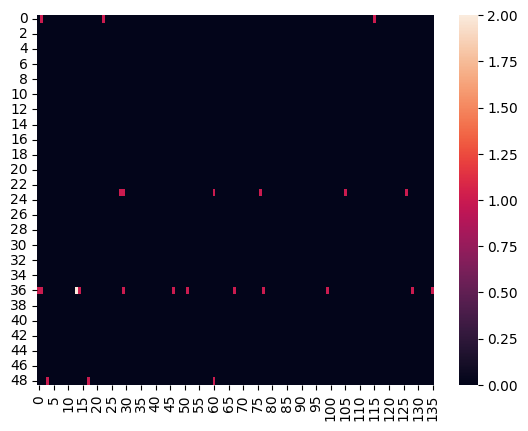

In [37]:
ripnum = 0
rip_begin = ripples_3sdpeak_df['start_time'].iloc[ripnum]
rip_end = ripples_3sdpeak_df['end_time'].iloc[ripnum]

# this is an examples of how to work the code, it is not the final code
# but without the whole time series you can't see the relative spike rate of the units
ca1_units = session.units[session.units['structure_acronym']=='CA1']
ca1_units_ids = ca1_units.index

ca1_units_firing_df = unit_spike_times_alyx_format(session, ca1_units_ids, start_time=rip_begin, stop_time=rip_end, as_array=False)

duration = rip_end - rip_begin
n_samples = SAMPLING_FREQUENCY * duration
time_vec = simulate_time(n_samples, SAMPLING_FREQUENCY)

spike_time_histogram, unit_ids, times  = np.histogram2d(
    x=ca1_units_firing_df.units.to_numpy(),
    y=ca1_units_firing_df.times.to_numpy(),
    bins=(len(ca1_units_ids), time_vec.shape[0]))

sns.heatmap(spike_time_histogram)

In [38]:
unfitlered_riples_csv_path = os.path.join(input_dir, 'swrs_session_{}'.format(session_id), 'session_{}_probe_{}_swrs.csv'.format(session_id, probe_id))
unfitlered_riples_csv_df = pd.read_csv(fitlered_riples_csv_path, index_col=0)
print(unfitlered_riples_csv_df.shape)
unfitlered_riples_csv_df.head()

(1800, 19)


,event_number,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed,Peak_Amp_RipBandPower,Peak_Amp_RipBandPower_zscore,Peak_time,Overlaps_with_gamma,Overlaps_with_movement
0,1,13.495037,13.530358,0.035321,2.440363,2.275194,5.094698,0.019185,0.0,0.0,0.0,0.0,0.0,0.0,5.498741e-10,2.612450,13.514364,False,False
1,2,13.545020,13.653649,0.108629,1.628958,1.273611,5.034624,0.019724,0.0,0.0,0.0,0.0,0.0,0.0,6.587586e-10,3.171678,13.597668,False,False
2,3,13.787603,13.884902,0.097300,1.972737,1.420189,4.272510,0.035159,0.0,0.0,0.0,0.0,0.0,0.0,4.909483e-10,2.309809,13.844916,False,False
3,4,22.497921,22.595887,0.097966,1.250430,0.783641,3.962733,0.016821,0.0,0.0,0.0,0.0,0.0,0.0,3.496823e-10,1.584270,22.530576,False,False
4,5,52.151657,52.234961,0.083304,1.432429,1.364055,2.843735,0.022346,0.0,0.0,0.0,0.0,0.0,0.0,2.589349e-10,1.118193,52.161653,False,False


In [19]:
# without specifying the time range you get the whole session
ca1_units_firing_df = unit_spike_times_alyx_format(session, ca1_units_ids, as_array=False)

duration = ca1_units_firing_df.times.to_numpy()[-1]
sampling_window_in_freq = 500
n_samples = sampling_window_in_freq * duration
time_vec = simulate_time(n_samples, SAMPLING_FREQUENCY)

# the histogram gieves us binned spiking activity, in this case in a window of 0.01s (10ms),
# this is not the same time bin as the lfp, we are then going to smooth it and z_score it
# then we will compare it to the lfp
# times is a vector that can be used as a bool mask to filter for times of interest
spike_time_histogram, unit_ids, times  = np.histogram2d(
    x=ca1_units_firing_df.units.to_numpy(),
    y=ca1_units_firing_df.times.to_numpy(),
    bins=(len(ca1_units_ids), time_vec.shape[0]))

#times = np.append(times, times[-1]+0.01)
# converting binned spikes to frequency and z_scoring them
frequency_matrix = spike_time_histogram*sampling_window_in_freq
frequency_matrix = halfgaussian_filter1d(spike_time_histogram, sigma = 0.015)
zscore_frequency_matrix = stats.zscore(frequency_matrix)


<AxesSubplot:>

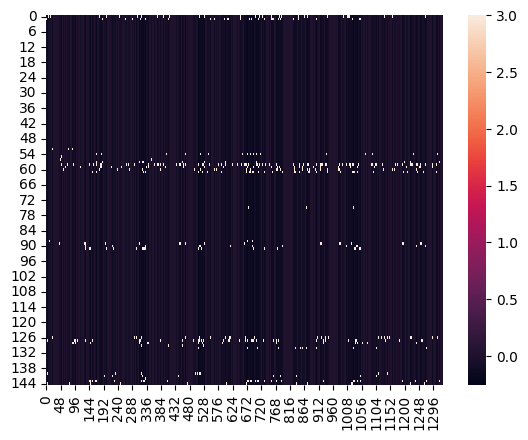

In [20]:
# plotting the zscored frequency matrix
rip_offset = 1
rip_time_mask = (times>(rip_begin-rip_offset))&(times<(rip_end+rip_offset))

# keeps the pltos scale from being too wide
plotting_mtrx = np.clip(zscore_frequency_matrix[:,rip_time_mask[:-1]], a_min=None, a_max=3)
# replaces the nan values with 0 to avoid producing ugly white stripes
plotting_mtrx = np.nan_to_num(plotting_mtrx)
sns.heatmap(plotting_mtrx)

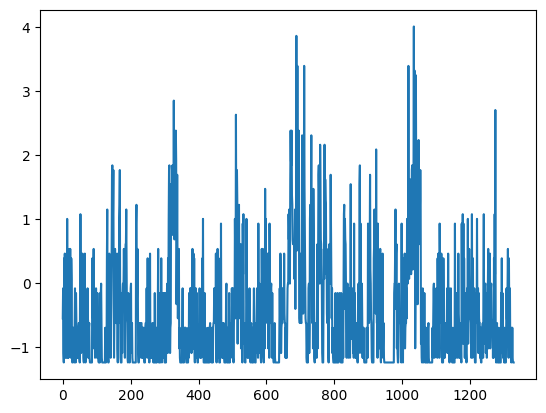

In [21]:
test = np.sum(spike_time_histogram, axis=0)

frequency = halfgaussian_filter1d(test, sigma = 0.5)
zscore_frequency = stats.zscore(frequency)
plt.plot(zscore_frequency[rip_time_mask[:-1]])

In [22]:
ripples_df = probe_event_dict[probe_list[probe_num]]
ripples_df = ripples_df[ripples_df.Overlaps_with_gamma==False]
ripples_df = ripples_df[ripples_df.Overlaps_with_movement==False]

In [23]:
highest_peaks = ripples_df['max_zscore'].nlargest(5).index
highest_peaks

Int64Index([1359, 286, 3984, 487, 203], dtype='int64')

0.0817542129284447


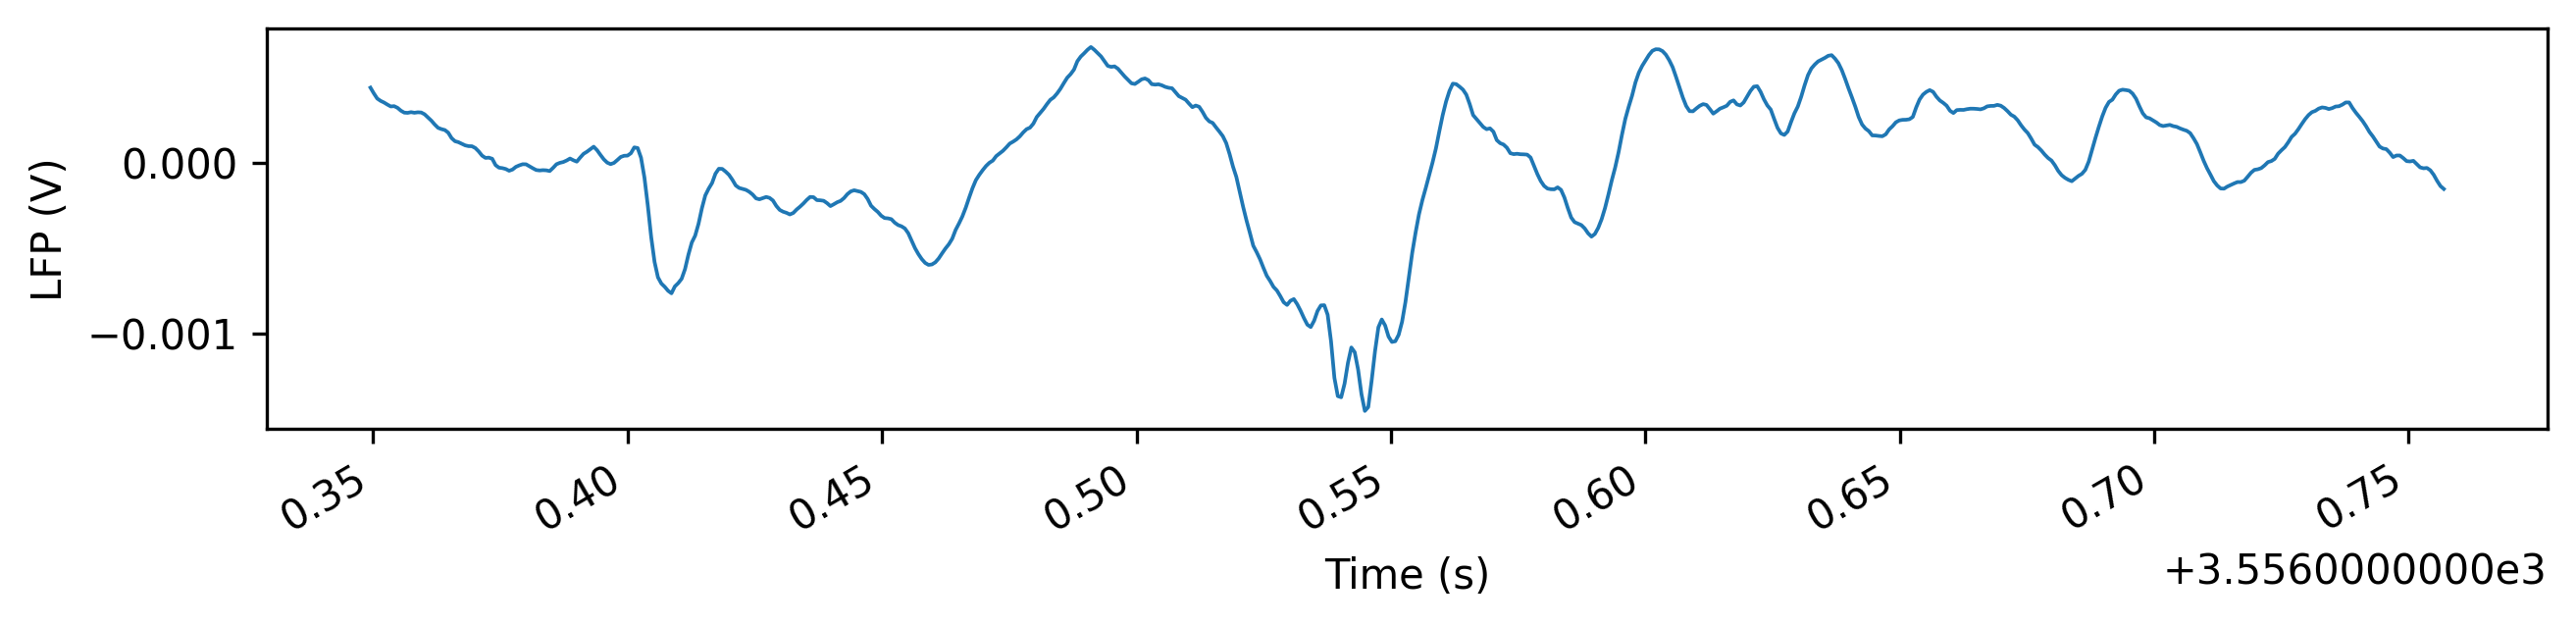

In [24]:
rip_num = highest_peaks[0]
print(ripples_df.duration[rip_num])
lasts = ripples_df.duration[rip_num]
rip_offset = (lasts*2)
rip_begin = ripples_df.start_time[rip_num]-rip_offset
rip_end = ripples_df.end_time[rip_num]+rip_offset

# withxarray
#this_chan_slice = this_chan.sel(time=slice(rip_begin, rip_end))
times_mask = (lfp_time_index>rip_begin) & (lfp_time_index<rip_end)
ripple_times_values = lfp_time_index[times_mask]
this_ripple_slice = lfp_ca1[times_mask]

plt.figure(figsize=(10,2), dpi=300)
_ = plt.plot(ripple_times_values, this_ripple_slice, linewidth=0.9)

plt.xlabel('Time (s)')
plt.ylabel('LFP (V)')

plt.gcf().autofmt_xdate()

In [27]:
# choose ripple number to plot from the highest peaks
rip_num = highest_peaks[0]

0.0817542129284447


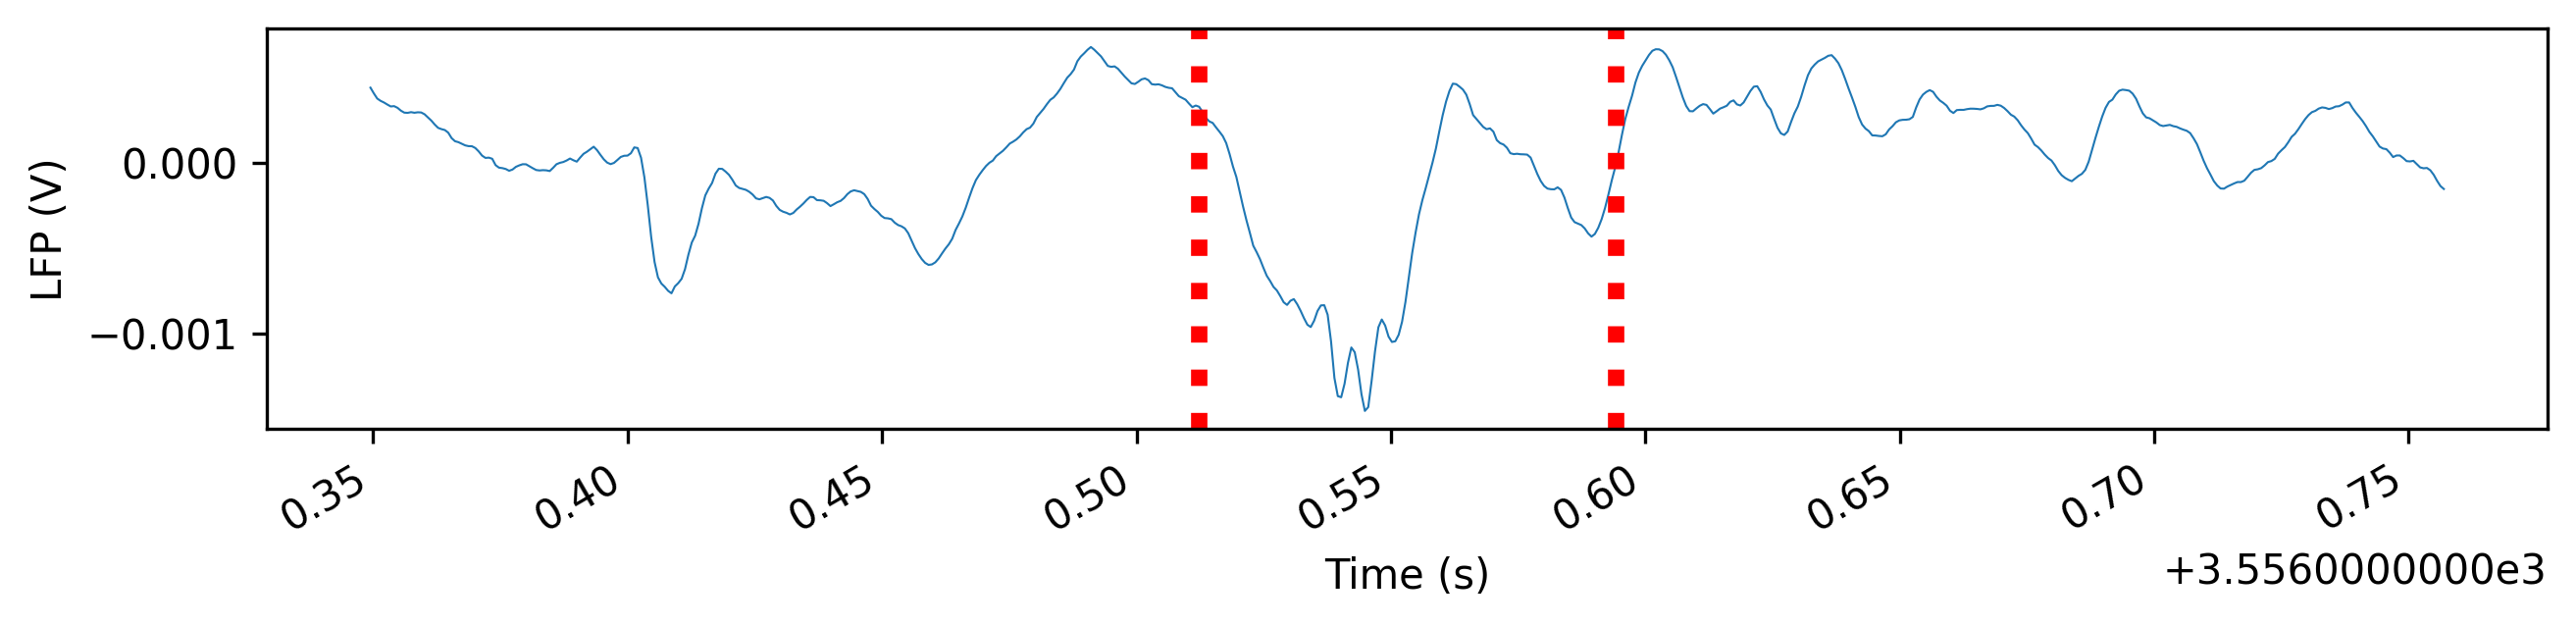

In [26]:
lasts = ripples_df.duration[rip_num]
rip_offset = (lasts*2)
rip_begin = ripples_df.start_time[rip_num]-rip_offset
rip_end = ripples_df.end_time[rip_num]+rip_offset

times_mask = (lfp_time_index>rip_begin) & (lfp_time_index<rip_end)
ripple_times_values = lfp_time_index[times_mask]
this_ripple_slice = lfp_ca1[times_mask]

plt.figure(figsize=(10,2), dpi=300)
_ = plt.plot(ripple_times_values, this_ripple_slice, linewidth=0.5)

# Add red dotted lines
plt.axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
plt.axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)


plt.xlabel('Time (s)')
plt.ylabel('LFP (V)')

plt.gcf().autofmt_xdate()

In [ ]:
lasts = ripples_df.duration[rip_num]
rip_offset = (lasts*2)
rip_begin = ripples_df.start_time[rip_num]-rip_offset
rip_end = ripples_df.end_time[rip_num]+rip_offset

times_mask = (lfp_time_index>rip_begin) & (lfp_time_index<rip_end)
ripple_times_values = lfp_time_index[times_mask]
this_ripple_slice = lfp_ca1[times_mask]

plt.figure(figsize=(10,2), dpi=300)
_ = plt.plot(ripple_times_values, this_ripple_slice, linewidth=0.5)

# Add red dotted lines
plt.axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
plt.axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)


plt.xlabel('Time (s)')
plt.ylabel('LFP (V)')

plt.gcf().autofmt_xdate()

In [28]:
zscore_rip_power

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

ValueError: x and y must have same first dimension, but have shapes (510,) and (511,)

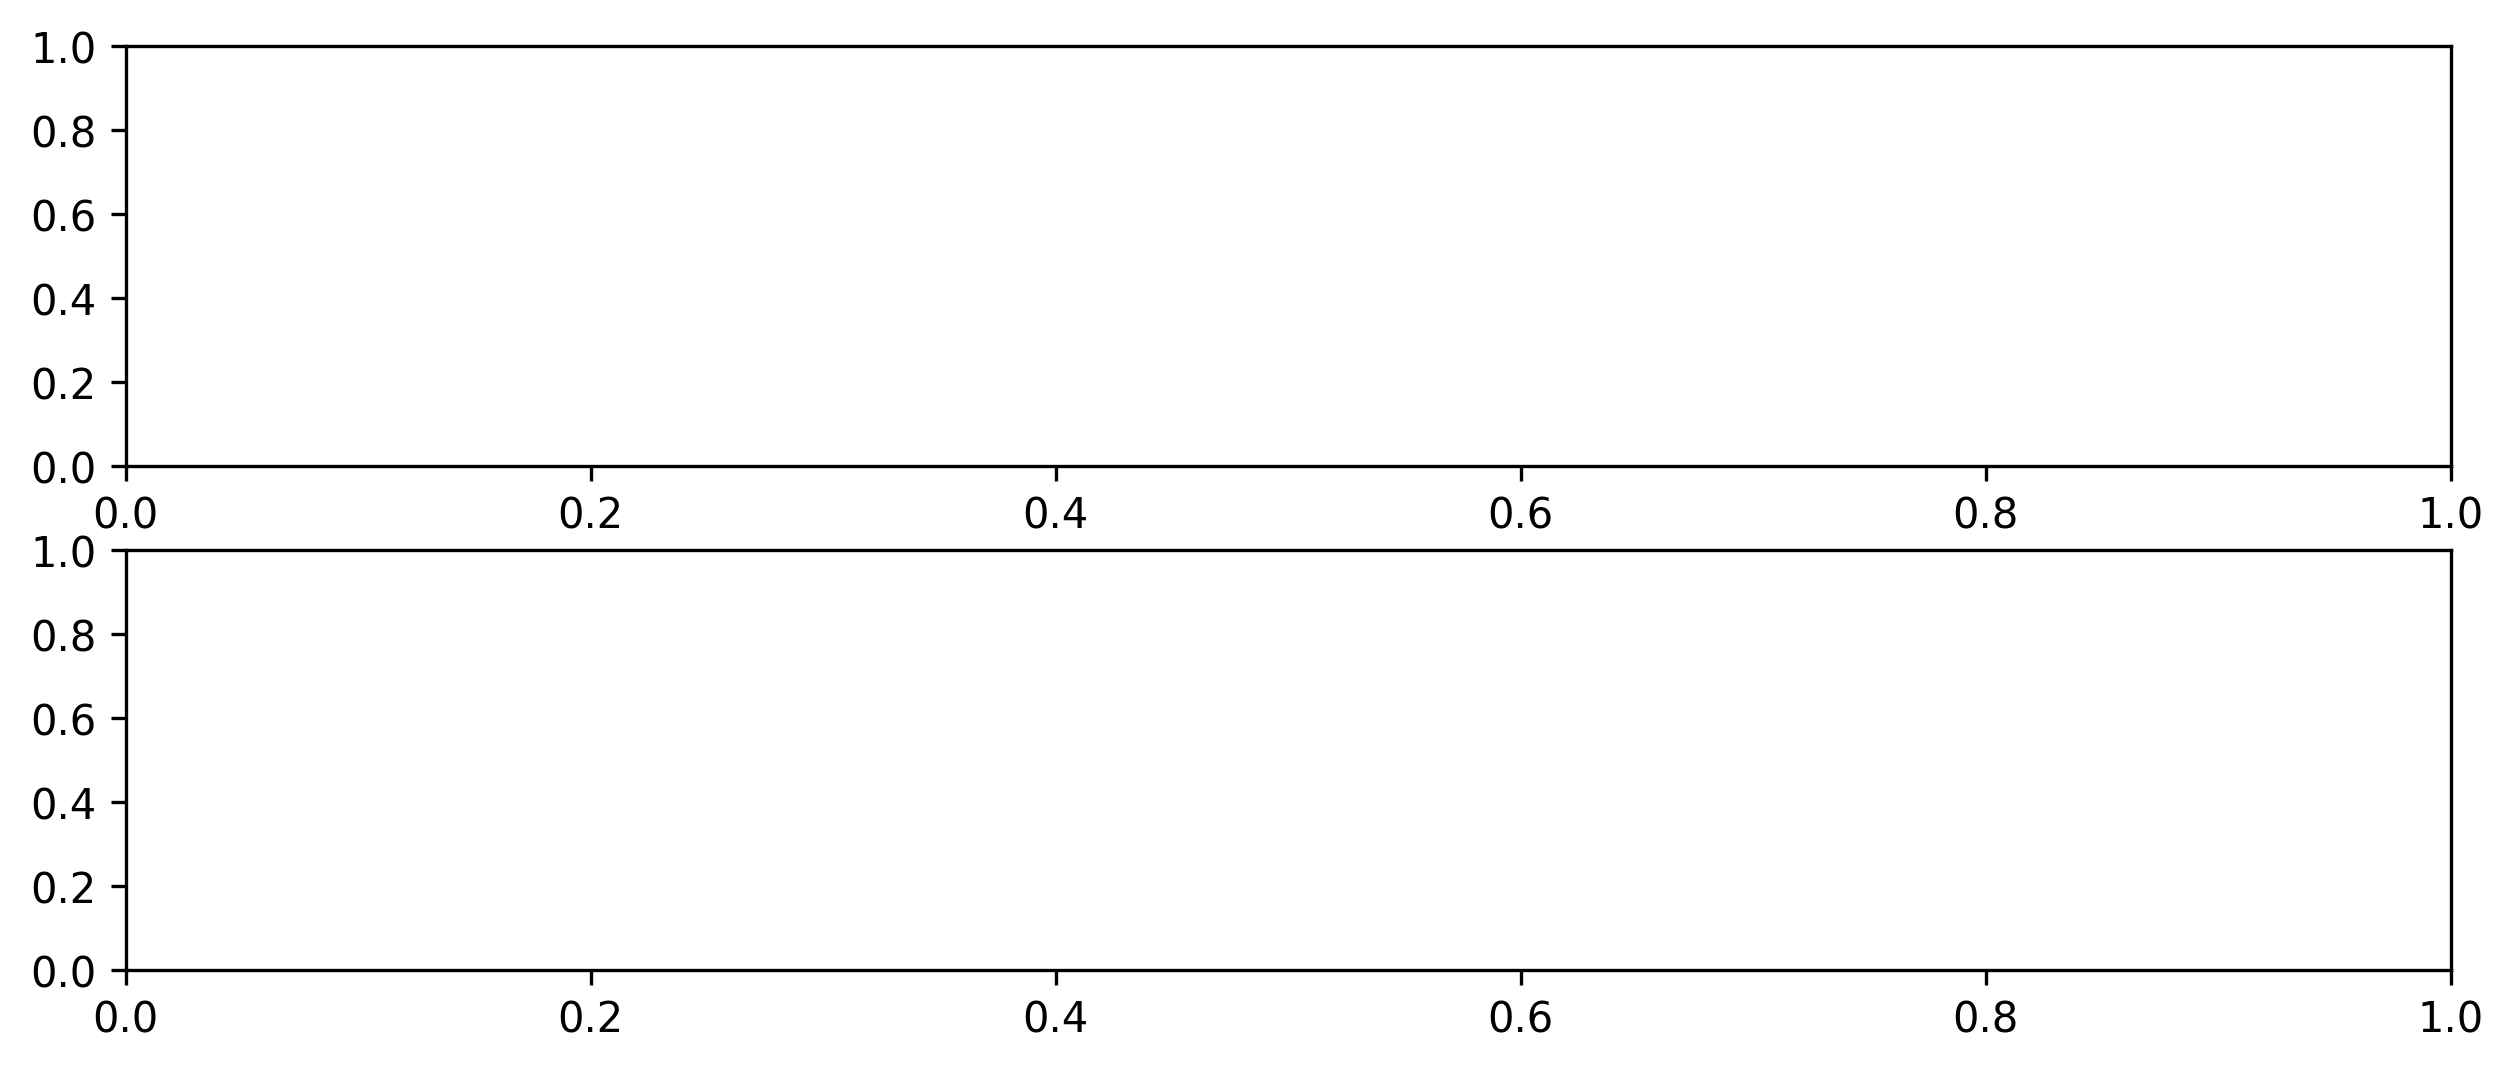

In [68]:
rip_num = highest_peaks[0]
lasts = ripples_df.duration[rip_num]
rip_offset = (lasts*2)
rip_begin = ripples_df.start_time[rip_num]-rip_offset
rip_end = ripples_df.end_time[rip_num]+rip_offset


times_mask = (lfp_time_index>rip_begin) & (lfp_time_index<rip_end)
ripple_times_values = lfp_time_index[times_mask]
this_ripple_slice = lfp_ca1[times_mask]

zscore_rip_power_slice = zscore_rip_power[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]
rip_band_slice = rip_band[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]

fig, axs = plt.subplots(2, 1, figsize=(10,4), dpi=300)

# Plot z-scored power
axs[0].plot(this_chan_slice.time.to_numpy()[:-1], zscore_rip_power_slice, linewidth=1)
axs[0].axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[0].axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[0].set_ylabel('Ripple Band Power')

# Plot frequency band
axs[1].plot(this_chan_slice.time.to_numpy()[:-1], rip_band_slice, linewidth=1)
axs[1].axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[1].axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Ripple Band (150-250 Hz)')

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

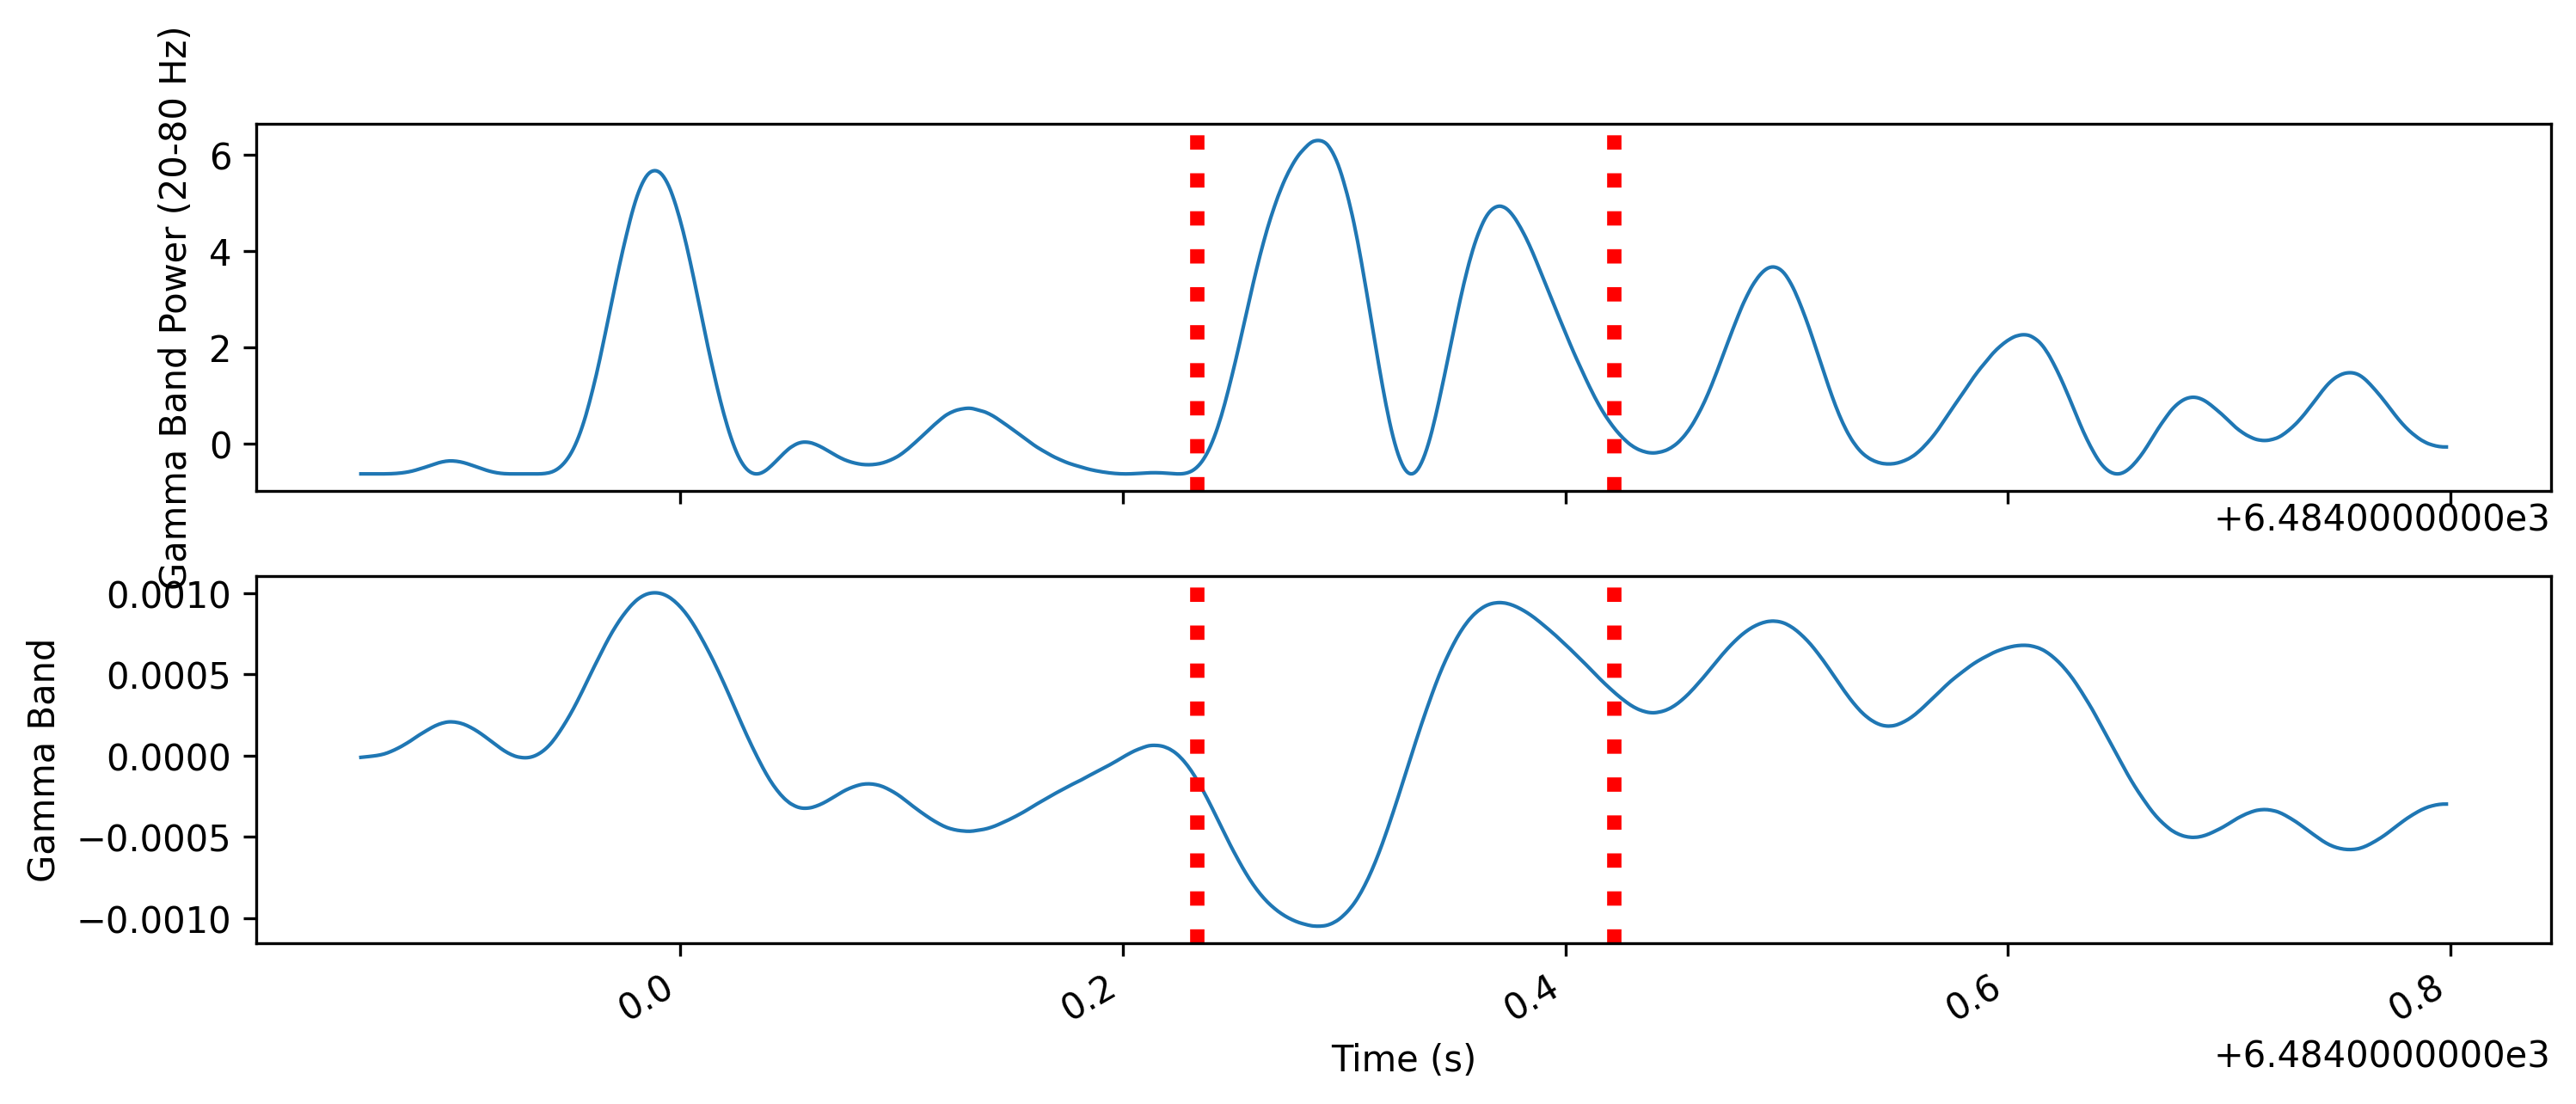

In [71]:
zscore_gamma_power_slice = zscore_gamma_power[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]
gamma_band_slice = gamma_band[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]

fig, axs = plt.subplots(2, 1, figsize=(10,4), dpi=300)

# Plot z-scored power
axs[0].plot(this_chan_slice.time.to_numpy()[:-1], zscore_gamma_power_slice, linewidth=1)
axs[0].axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[0].axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[0].set_ylabel('Gamma Band Power (20-80 Hz)')

# Plot frequency band
axs[1].plot(this_chan_slice.time.to_numpy()[:-1], gamma_band_slice, linewidth=1)
axs[1].axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[1].axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Gamma Band')

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

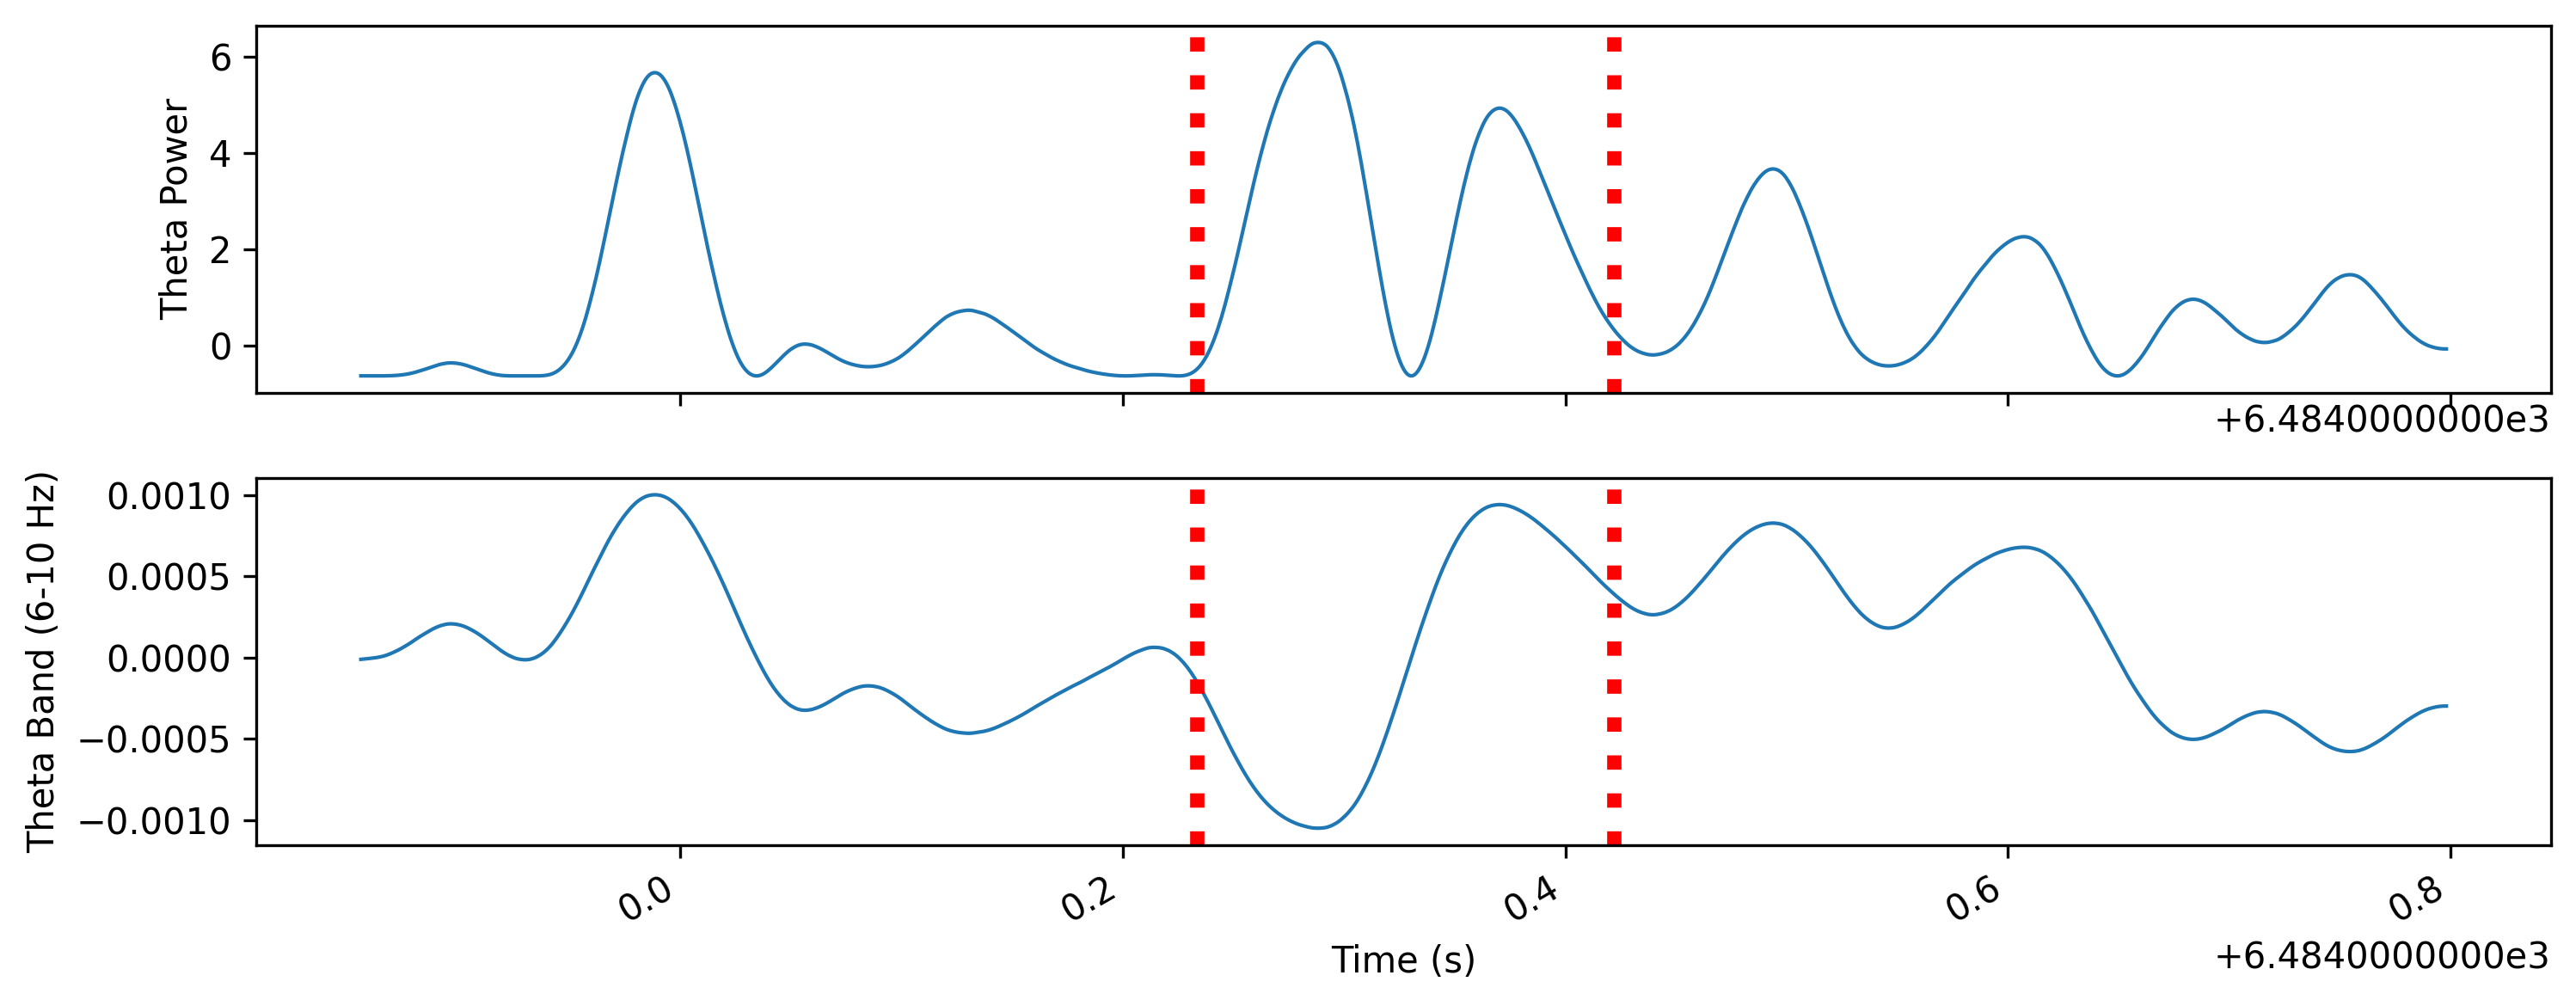

In [73]:
zscore_theta_power_slice = zscore_theta_power[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]
theta_band_slice = theta_band[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]

fig, axs = plt.subplots(2, 1, figsize=(10,4), dpi=300)

# Plot z-scored power
axs[0].plot(this_chan_slice.time.to_numpy()[:-1], zscore_theta_power_slice, linewidth=1)
axs[0].axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[0].axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[0].set_ylabel('Theta Power')

# Plot frequency band
axs[1].plot(this_chan_slice.time.to_numpy()[:-1], theta_band_slice, linewidth=1)
axs[1].axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[1].axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Theta Band (6-10 Hz)')

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [ ]:
rip_num = highest_peaks[0]
print(ripples_df.duration[rip_num])
lasts = ripples_df.duration[rip_num]
rip_offset = (lasts*2)
rip_begin = ripples_df.start_time[rip_num]-rip_offset
rip_end = ripples_df.end_time[rip_num]+rip_offset

zscore_sharpwave_power_slice = zscore_sharpwave_power[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]

plt.figure(figsize=(10,2), dpi=300)
_ = plt.plot(this_chan_slice.time.to_numpy()[:-1], zscore_sharpwave_power_slice, linewidth=1)

# Add red dotted lines
plt.axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
plt.axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)


plt.xlabel('Time (s)')
plt.ylabel('Sharp-Wave Power (8-40 Hz)')

plt.gcf().autofmt_xdate()

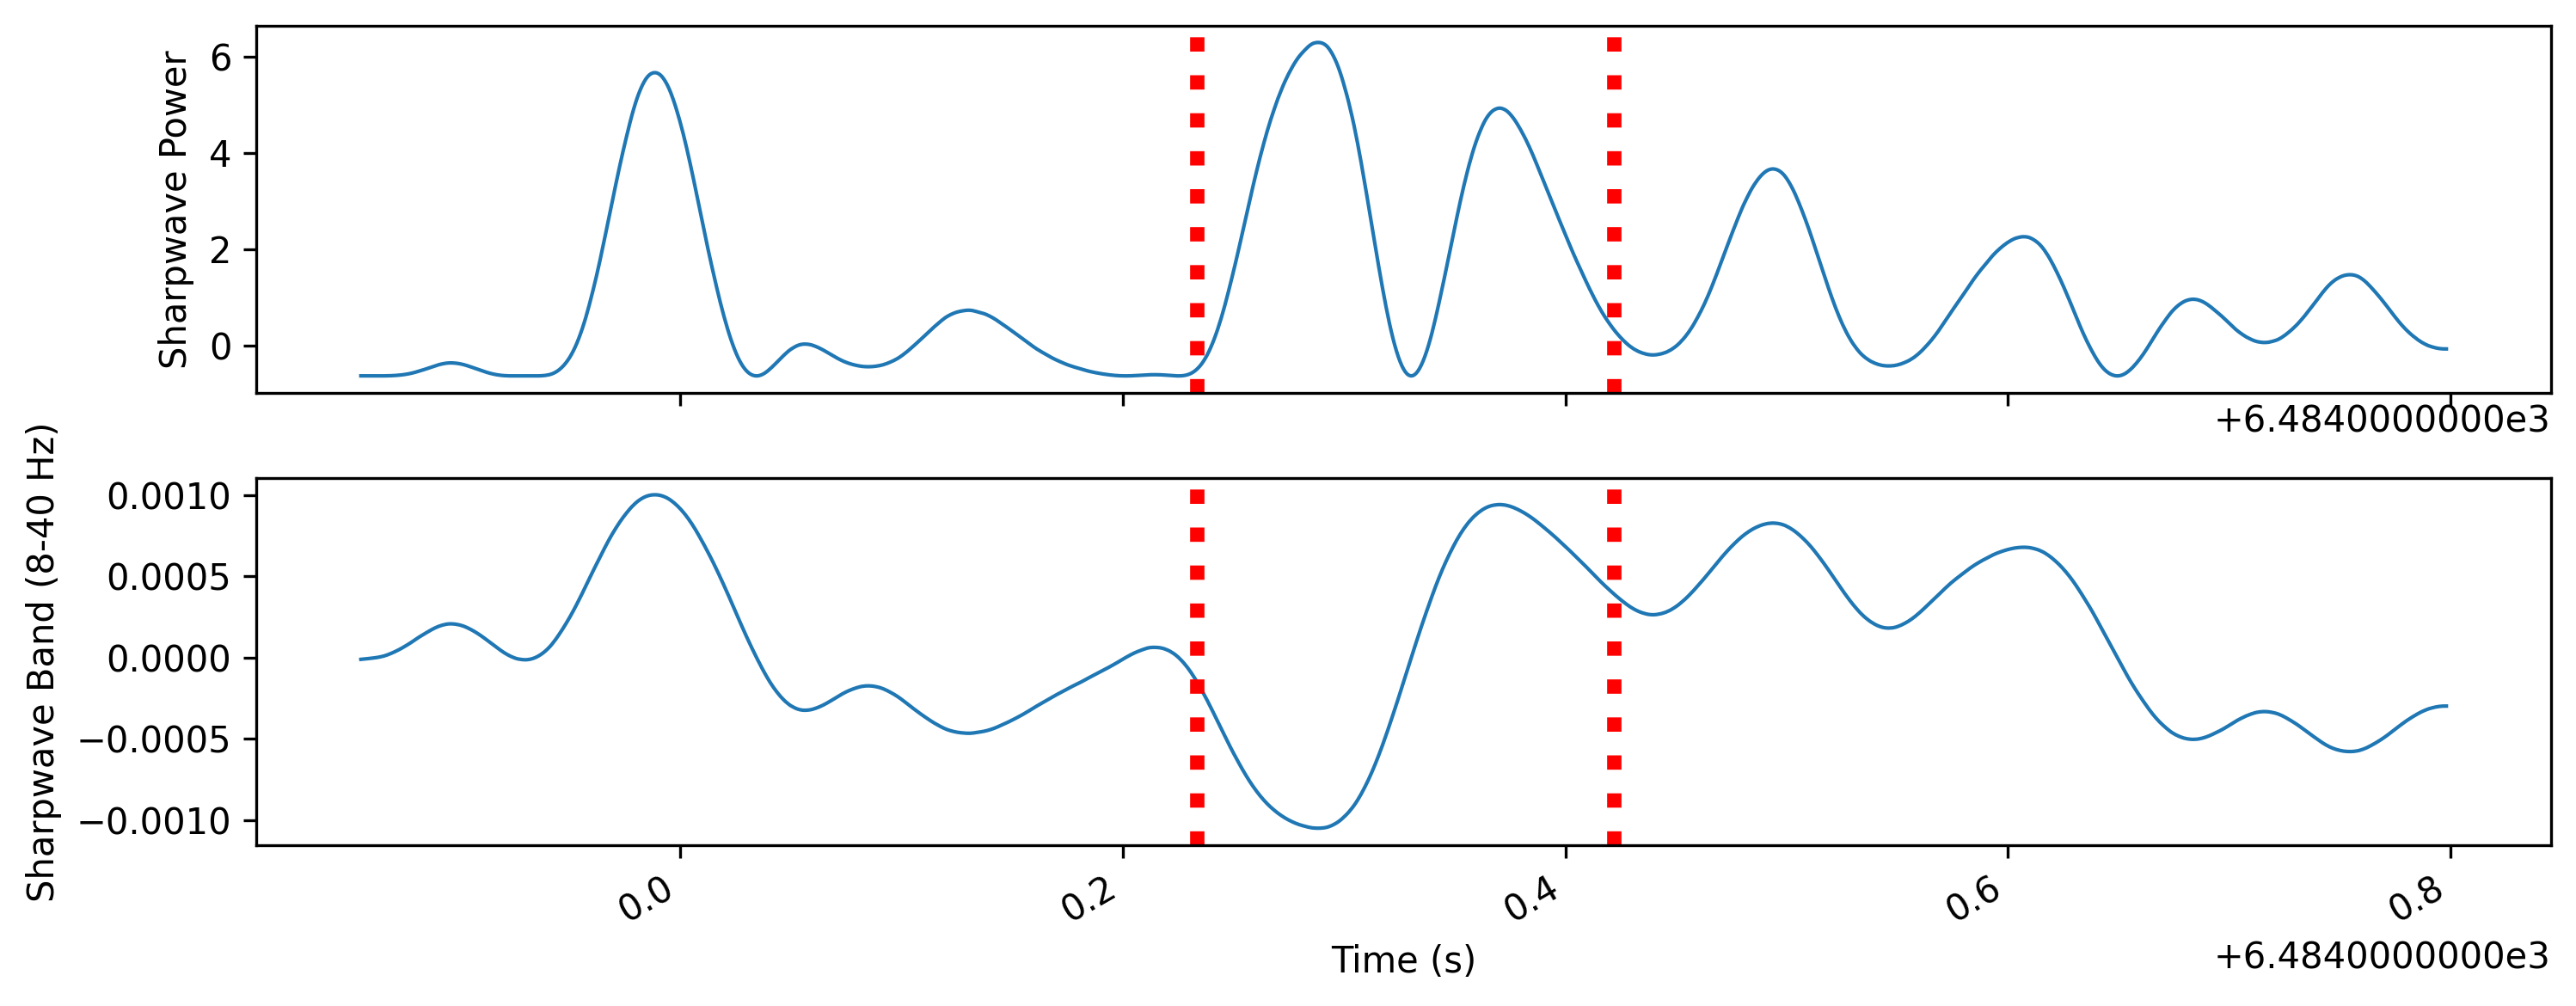

In [72]:
zscore_sharpwave_power_slice = zscore_sharpwave_power[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]
sharpwave_band_slice = sharpwave_band[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]

fig, axs = plt.subplots(2, 1, figsize=(10,4), dpi=300)

# Plot z-scored power
axs[0].plot(this_chan_slice.time.to_numpy()[:-1], zscore_sharpwave_power_slice, linewidth=1)
axs[0].axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[0].axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[0].set_ylabel('Sharpwave Power')

# Plot frequency band
axs[1].plot(this_chan_slice.time.to_numpy()[:-1], sharpwave_band_slice, linewidth=1)
axs[1].axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[1].axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Sharpwave Band (8-40 Hz)')

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

0.1888005078426431


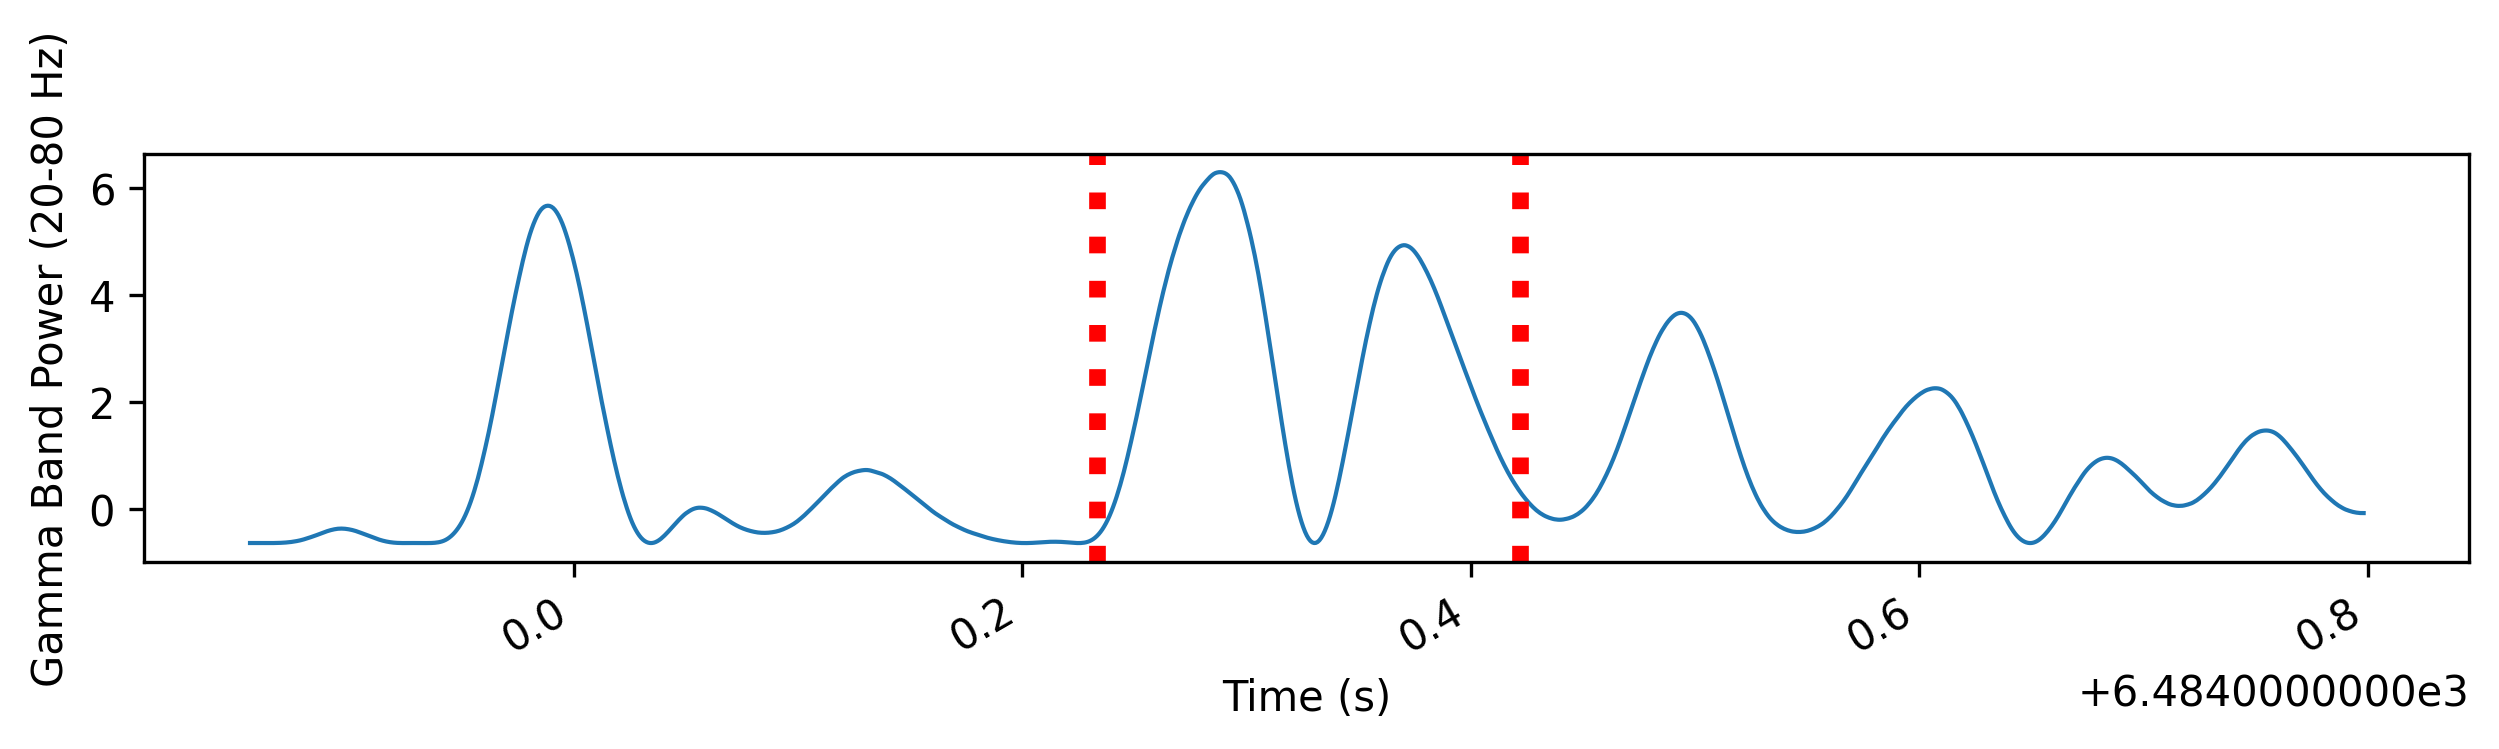

In [ ]:
rip_num = highest_peaks[0]
print(ripples_df.duration[rip_num])
lasts = ripples_df.duration[rip_num]
rip_offset = (lasts*2)
rip_begin = ripples_df.start_time[rip_num]-rip_offset
rip_end = ripples_df.end_time[rip_num]+rip_offset

zscore_gamma_power_slice = zscore_gamma_power[(this_chan.time>rip_begin)&(this_chan.time<rip_end)]

plt.figure(figsize=(10,2), dpi=300)
_ = plt.plot(this_chan_slice.time.to_numpy()[:-1], zscore_gamma_power_slice, linewidth=1)

# Add red dotted lines
plt.axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
plt.axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)


plt.xlabel('Time (s)')
plt.ylabel('Gamma Band Power (20-80 Hz)')

plt.gcf().autofmt_xdate()

0.1888005078426431


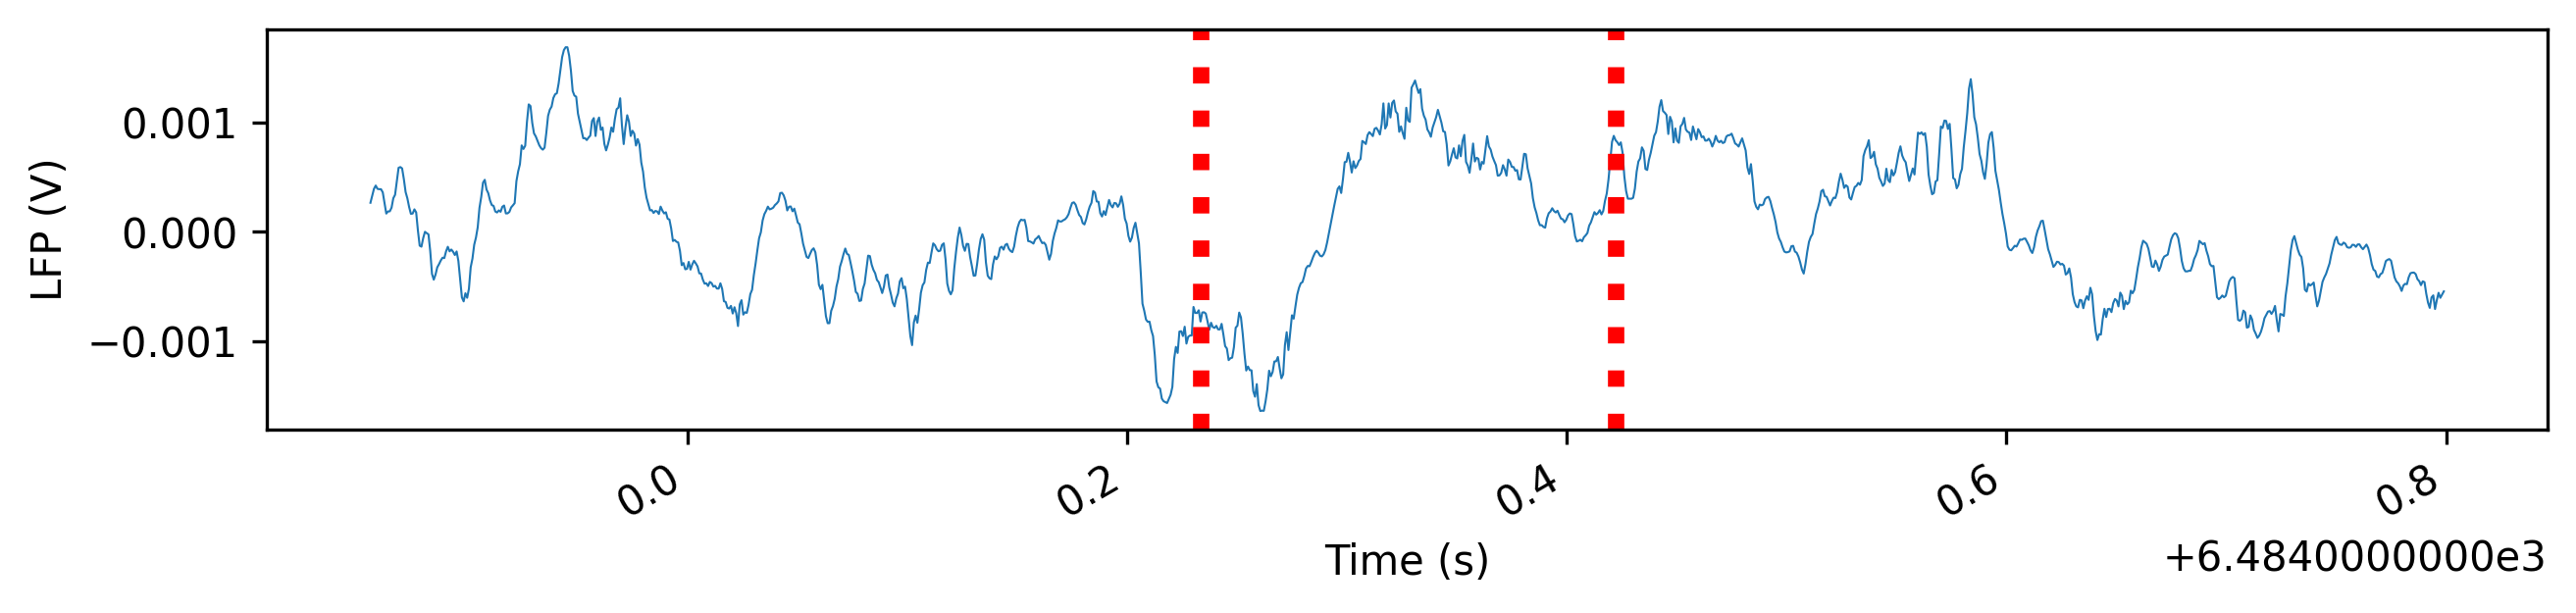

In [63]:
rip_num = highest_peaks[0]
print(ripples_df.duration[rip_num])
lasts = ripples_df.duration[rip_num]
rip_offset = (lasts*2)
rip_begin = ripples_df.start_time[rip_num]-rip_offset
rip_end = ripples_df.end_time[rip_num]+rip_offset

this_chan_slice = this_chan.sel(time=slice(rip_begin, rip_end))

plt.figure(figsize=(10,2), dpi=300)
_ = plt.plot(this_chan_slice.time, this_chan_slice, linewidth=0.5)

# Add red dotted lines
plt.axvline(x=ripples_df.start_time[rip_num], color='r', linestyle=':', linewidth=4)
plt.axvline(x=ripples_df.end_time[rip_num], color='r', linestyle=':', linewidth=4)


plt.xlabel('Time (s)')
plt.ylabel('LFP (V)')

plt.gcf().autofmt_xdate()

In [64]:
# Create an array of multiples of 0.25 within the range of your data
multiples = np.arange(np.min(actual_time_values), np.max(actual_time_values), 0.25)#multiples
# Find the index of the closest value in your data for each multiple
closest_indices = [np.abs(actual_time_values - m).argmin() for m in multiples]
closest_values = actual_time_values[closest_indices]
closest_values

NameError: name 'actual_time_values' is not defined

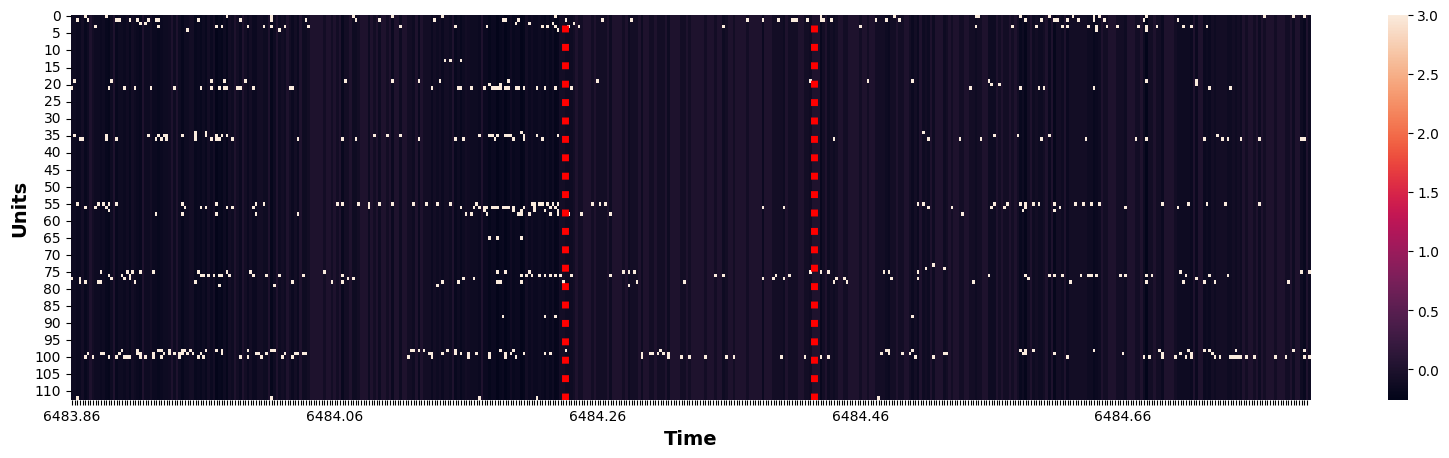

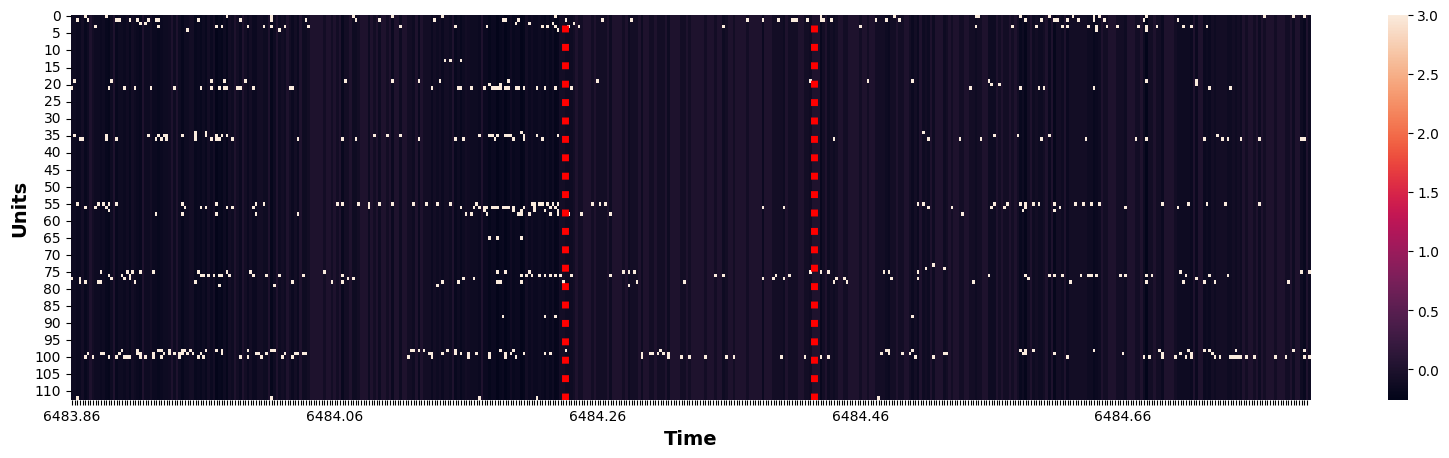

In [ ]:
# plotting the zscored frequency matrix
rip_offset = (lasts*2)
rip_time_mask = (times>rip_begin)&(times<rip_end) # already incorperates offset


actual_time_values = times[rip_time_mask]
actual_time_values = actual_time_values[:-1]
# Create an array of multiples of 0.25 within the range of your data
multiples = np.arange(np.min(actual_time_values), np.max(actual_time_values), 0.2)#multiples
# Find the index of the closest value in your data for each multiple
closest_indices = [np.abs(actual_time_values - m).argmin() for m in multiples]
closest_values = actual_time_values[closest_indices]
closest_values = np.round(closest_values, 2)
mapping = dict(zip(closest_indices, closest_values))

# Create a new list of labels with the same length as the number of columns in the data
labels = [''] * len(actual_time_values)

# Set the labels for the indices corresponding to the closest values to multiples of 0.25
for i in range(len(actual_time_values)):
    if i in mapping:
        labels[i] = str(mapping[i])

# keeps the pltos scale from being too wide
plotting_mtrx = np.clip(zscore_frequency_matrix[:,rip_time_mask[:-1]], a_min=None, a_max=3)
plotting_mtrx = np.nan_to_num(plotting_mtrx)
# replaces the nan values with 0 to avoid producing ugly white stripes
# Find the indices of rip_begin and rip_end in actual_time_values
rip_begin_index = np.abs(actual_time_values - ripples_df.start_time[rip_num]).argmin()
rip_end_index = np.abs(actual_time_values - ripples_df.end_time[rip_num]).argmin()

# Create the heatmap
plt.figure(figsize=(20, 5))
ax = sns.heatmap(plotting_mtrx, xticklabels=labels)

# Add vertical lines at rip_begin and rip_end
ax.axvline(x=rip_begin_index, color='r', linestyle=':', linewidth=5)
ax.axvline(x=rip_end_index, color='r', linestyle=':', linewidth=5)

# Set x and y axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Units')

ax.set_xlabel('Time', fontsize=14, weight='bold')
ax.set_ylabel('Units', fontsize=14, weight='bold')
plt.show()

In [ ]:
def unit_spike_times_alyx_format(session_obj, unit_ids, start_time=0, stop_time=np.inf, as_array=False):
    """
    Returns a DataFrame of spike times for multiple units in a session in the format
    according to the Alyx format
    
    Parameters
    ----------
    session : allensdk session object
    unit_ids : list of unit ids (obtained by session.units.index)
    start_time : float, optional, start time of spike times
    stop_time : float, optional, stop time of spike times
    as_array : bool, optional, if True returns a numpy array instead of a DataFrame
    
    Returns
    -------
    DataFrame or numpy array of spike times
    """
    df = pd.DataFrame(columns=['units', 'times'])

    for unit_id in unit_ids:
        ca1_unit_time = np.array(session_obj.spike_times[unit_id])
        filtered_time = ca1_unit_time[(ca1_unit_time > start_time) & (ca1_unit_time < stop_time)]
        unit_ids_array = np.full(filtered_time.shape, unit_id)
        
        df_temp = pd.DataFrame({
            'units': unit_ids_array,
            'times': filtered_time
        })
        
        df = df.append(df_temp, ignore_index=True)

    df = df.sort_values(by='times')

    if as_array:
        return df.values
    else:
        return df

In [ ]:

def filter_time(session, unit_ids, start_time=0, stop_time=np.inf):
    unit_id = unit_ids[0]
    ca1_unit_time = np.array(session.spike_times[unit_id])
    filtered_time = ca1_unit_time[(ca1_unit_time > start_time) & (ca1_unit_time < stop_time)]
    unit_ids_array = np.full(filtered_time.shape, unit_id)
    
    df = pd.DataFrame({
        'units': unit_ids_array,
        'times': filtered_time
    })

    for unit_id in unit_ids[1:]:
        ca1_unit_time = np.array(session.spike_times[unit_id])
        filtered_time = ca1_unit_time[(ca1_unit_time > start_time) & (ca1_unit_time < stop_time)]
        unit_ids_array = np.full(filtered_time.shape, unit_id)
        
        df_temp = pd.DataFrame({
            'units': unit_ids_array,
            'times': filtered_time
        })
        
        df = df.append(df_temp, ignore_index=True)

In [ ]:
# get unit id's from CA1

ca1_unit_times = presentationwise_spike_times( unit_ids=ca1_units)